In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from lightgbm import plot_importance
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
import pandas as pd

churn_data = pd.read_csv('./data/churn_data.csv',encoding = 'cp949')

In [1]:
# churn_data.info()

In [4]:
churn_data['mbr_sex_cd'].unique()

array(['M', 'F', 'X'], dtype=object)

In [5]:
churn_data['grade_sect_cd'].unique()

array(['G011', 'G012', 'G013', 'G014', 'G015', 'G016'], dtype=object)

In [6]:
churn_data['re_purch'].value_counts()

False    46908
True     13092
Name: re_purch, dtype: int64

## 데이터 전처리

In [ ]:
# 해당데이터에는 결측치가 없음이 확인된다.
null_cnt_df = pd.DataFrame(churn_data.isnull().sum()).rename(columns = {0:'null_count'}).reset_index()
null_cnt_df['null_ratio'] = round(null_cnt_df['null_count']/len(churn_data) * 100, 2)
null_cnt_df

In [8]:
grade_dict = {'G011':1,'G012' :2, 'G013':3, 'G014':4, 'G015':5, 'G016':6 }
churn_data['grade'] = churn_data['grade_sect_cd'].apply(lambda x: grade_dict[x])

In [9]:
churn_data['grade'].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

# 모델학습

In [10]:
# 학년과 성별을 기준으로 데이터를 나눈다.
from sklearn.metrics import precision_recall_fscore_support
def model_grade_sex(ind_x, sex):
    churn_grade_ind = churn_data[churn_data['re_purch']==False]
    if ind_x == '저학년':
        ind_value = [1,2,3]
    elif ind_x == '고학년':
        ind_value = [4,5,6]
    else:
        return
    
    churn_grade_ind = churn_data[churn_data['grade'].isin(ind_value)]
    churn_grade_ind = churn_grade_ind[churn_grade_ind['mbr_sex_cd'] == sex ]
    X_ind = churn_grade_ind[['tmon_pchrg_lrn_dcnt',
                                 'acmlt_pchrg_lrn_dcnt','acmlt_bilclct_amt',
                                 'correct_rate_avg','learning_time_avg',
                                 'media_action_cnt_sum','non_video_viewed_cnt_sum','get_mm_point_sum']]

    y_ind = churn_grade_ind['label']
    
    if sex=='M':
        sex = '남자'
    else:
        sex = '여자'

    
    X_train, X_test, y_train, y_test = train_test_split(X_ind, y_ind, test_size = 0.2, random_state= 777)
    print("[Train] {}  {}, 이탈 : {}, 미이탈 : {}".format(ind_x, sex, y_train[y_train ==1].shape[0], y_train[y_train ==0].shape[0]))
    print("[Test]  {}  {},  이탈 : {}, 미이탈 : {}".format(ind_x, sex, y_test[y_test ==1].shape[0], y_test[y_test ==0].shape[0]))

    
    
    lgbm_model = LGBMClassifier(random_state=0, verbose= -1)
    lgbm_model.fit(X_train, y_train)
    y_pred = lgbm_model.predict(X_test)
    y_pred = list(y_pred)
    
    print(f"[predict] {ind_x} {sex} 이탈: {y_pred.count(1)}, 미이탈: {y_pred.count(0)}")
    
    print()
    
    cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels = [1,0]),
    index = ['실제: 이탈 (1)', '실제: 미이탈(0)'],
    columns = ['예측 : 이탈(1)', '예측 : 미이탈(0)']
    )
    print(cmtx)
    print()
    
    pre, re, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    print(f'precision : {pre}\nrecall : {re}\nF1 : {f1}')
    
    fig, ax = plt.subplots(figsize=(5,5))
    plot_importance(lgbm_model, ax=ax)
    plt.show()
    

[Train] 저학년  남자, 이탈 : 190, 미이탈 : 13410
[Test]  저학년  남자,  이탈 : 57, 미이탈 : 3343
[predict] 저학년 남자 이탈: 47, 미이탈: 3353

            예측 : 이탈(1)  예측 : 미이탈(0)
실제: 이탈 (1)          43           14
실제: 미이탈(0)           4         3339

precision : 0.9148936170212766
recall : 0.7543859649122807
F1 : 0.8269230769230769


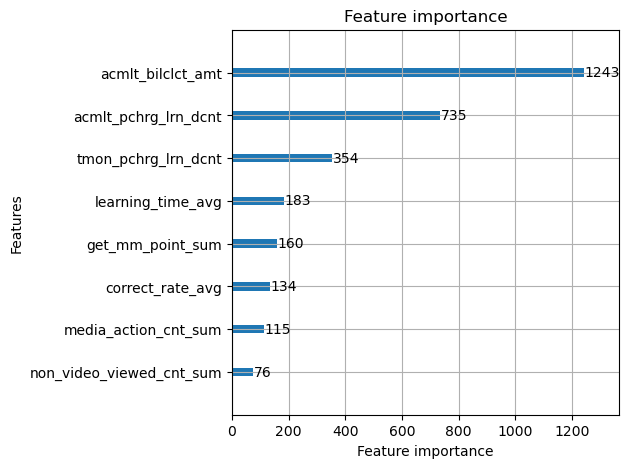

[Train] 저학년  여자, 이탈 : 103, 미이탈 : 9529
[Test]  저학년  여자,  이탈 : 37, 미이탈 : 2372
[predict] 저학년 여자 이탈: 20, 미이탈: 2389

            예측 : 이탈(1)  예측 : 미이탈(0)
실제: 이탈 (1)          16           21
실제: 미이탈(0)           4         2368

precision : 0.8
recall : 0.43243243243243246
F1 : 0.5614035087719298


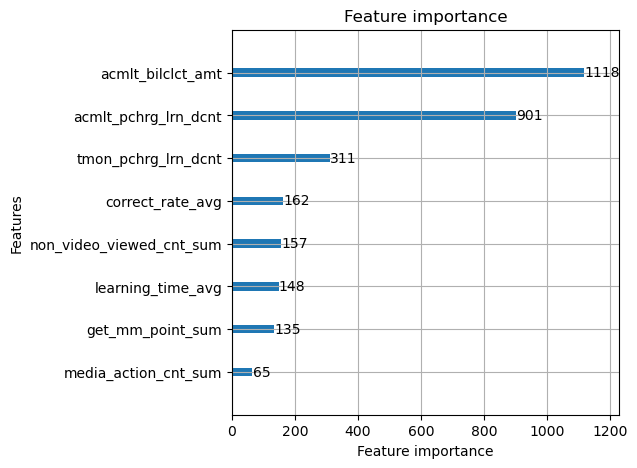

[Train] 고학년  남자, 이탈 : 232, 미이탈 : 12442
[Test]  고학년  남자,  이탈 : 54, 미이탈 : 3115
[predict] 고학년 남자 이탈: 45, 미이탈: 3124

            예측 : 이탈(1)  예측 : 미이탈(0)
실제: 이탈 (1)          35           19
실제: 미이탈(0)          10         3105

precision : 0.7777777777777778
recall : 0.6481481481481481
F1 : 0.707070707070707


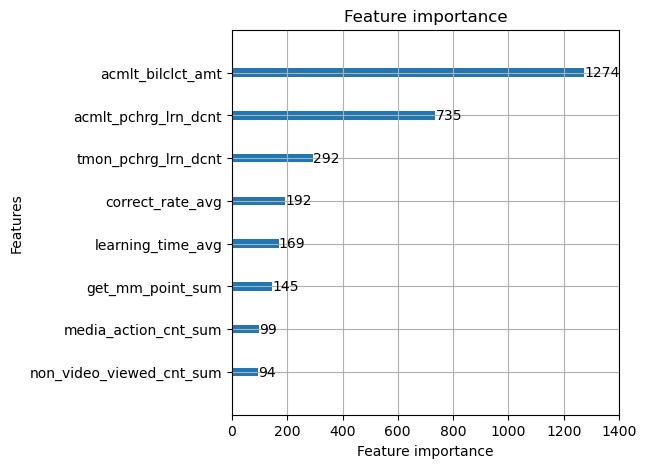

[Train] 고학년  여자, 이탈 : 194, 미이탈 : 10526
[Test]  고학년  여자,  이탈 : 43, 미이탈 : 2637
[predict] 고학년 여자 이탈: 50, 미이탈: 2630

            예측 : 이탈(1)  예측 : 미이탈(0)
실제: 이탈 (1)          35            8
실제: 미이탈(0)          15         2622

precision : 0.7
recall : 0.813953488372093
F1 : 0.7526881720430109


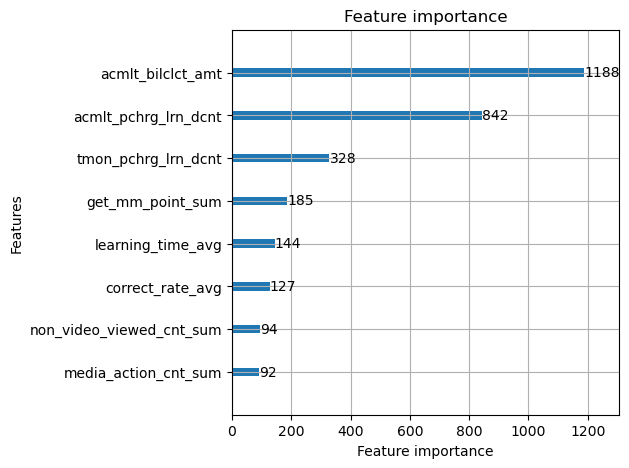

In [55]:
for grade in ['저학년', '고학년']:
    for sex in ['M','F']:
        model_grade_sex(grade, sex)

# 저학년 여자에 대한 모델 재생성

[Train] 저학년  여자, 이탈 : 103, 미이탈 : 9529
[Test]  저학년  여자,  이탈 : 37, 미이탈 : 2372
[predict] 저학년 여자 이탈: 26, 미이탈: 2383

            예측 : 이탈(1)  예측 : 미이탈(0)
실제: 이탈 (1)          21           16
실제: 미이탈(0)           5         2367

precision : 0.8076923076923077
recall : 0.5675675675675675
F1 : 0.6666666666666666


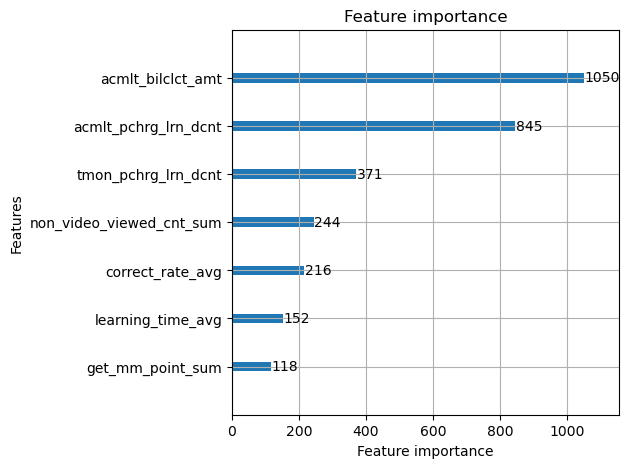

In [56]:

churn_grade_ind = churn_data[churn_data['re_purch']==False]
ind_x = '저학년'
ind_value = [1,2,3]
sex = 'F'

churn_grade_ind = churn_data[churn_data['grade'].isin(ind_value)]
churn_grade_ind = churn_grade_ind[churn_grade_ind['mbr_sex_cd'] == sex ]
X_ind = churn_grade_ind[['tmon_pchrg_lrn_dcnt',
                             'acmlt_pchrg_lrn_dcnt','acmlt_bilclct_amt',
                             'correct_rate_avg','learning_time_avg',
                             'non_video_viewed_cnt_sum','get_mm_point_sum']]
y_ind = churn_grade_ind['label']

class_weights = {0:1.0, 1:3.0}

if sex=='M':
    sex = '남자'
else:
    sex = '여자'


X_train, X_test, y_train, y_test = train_test_split(X_ind, y_ind, test_size = 0.2, random_state= 777)
print("[Train] {}  {}, 이탈 : {}, 미이탈 : {}".format(ind_x, sex, y_train[y_train ==1].shape[0], y_train[y_train ==0].shape[0]))
print("[Test]  {}  {},  이탈 : {}, 미이탈 : {}".format(ind_x, sex, y_test[y_test ==1].shape[0], y_test[y_test ==0].shape[0]))



lgbm_model = LGBMClassifier(class_weight=class_weights,random_state=0, verbose= -1)
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
y_pred = list(y_pred)

print(f"[predict] {ind_x} {sex} 이탈: {y_pred.count(1)}, 미이탈: {y_pred.count(0)}")

print()

cmtx = pd.DataFrame(
confusion_matrix(y_test, y_pred, labels = [1,0]),
index = ['실제: 이탈 (1)', '실제: 미이탈(0)'],
columns = ['예측 : 이탈(1)', '예측 : 미이탈(0)']
)
print(cmtx)
print()

pre, re, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f'precision : {pre}\nrecall : {re}\nF1 : {f1}')

fig, ax = plt.subplots(figsize=(5,5))
plot_importance(lgbm_model, ax=ax)
plt.show()

# 고학년 남자에 대한 모델 재설정
(저학년 여자 모델에 사용한 요소 그대로 사용)

[Train] 고학년  남자, 이탈 : 232, 미이탈 : 12442
[Test]  고학년  남자,  이탈 : 54, 미이탈 : 3115
[predict] 고학년 남자 이탈: 53, 미이탈: 3116

            예측 : 이탈(1)  예측 : 미이탈(0)
실제: 이탈 (1)          37           17
실제: 미이탈(0)          16         3099

precision : 0.6981132075471698
recall : 0.6851851851851852
F1 : 0.6915887850467289


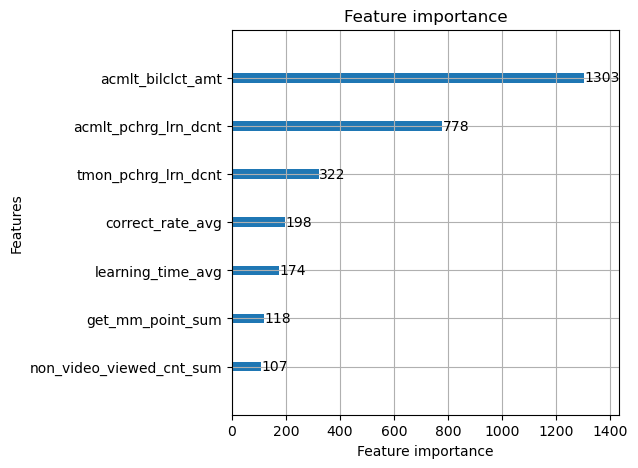

In [57]:

churn_grade_ind = churn_data[churn_data['re_purch']==False]
ind_x = '고학년'
ind_value = [4,5,6]
sex = 'M'

churn_grade_ind = churn_data[churn_data['grade'].isin(ind_value)]
churn_grade_ind = churn_grade_ind[churn_grade_ind['mbr_sex_cd'] == sex ]
X_ind = churn_grade_ind[['tmon_pchrg_lrn_dcnt',
                             'acmlt_pchrg_lrn_dcnt','acmlt_bilclct_amt',
                             'correct_rate_avg','learning_time_avg',
                             'non_video_viewed_cnt_sum','get_mm_point_sum']]
y_ind = churn_grade_ind['label']

class_weights = {0:1.0, 1:3.0}

if sex=='M':
    sex = '남자'
else:
    sex = '여자'


X_train, X_test, y_train, y_test = train_test_split(X_ind, y_ind, test_size = 0.2, random_state= 777)
print("[Train] {}  {}, 이탈 : {}, 미이탈 : {}".format(ind_x, sex, y_train[y_train ==1].shape[0], y_train[y_train ==0].shape[0]))
print("[Test]  {}  {},  이탈 : {}, 미이탈 : {}".format(ind_x, sex, y_test[y_test ==1].shape[0], y_test[y_test ==0].shape[0]))



lgbm_model = LGBMClassifier(class_weight=class_weights,random_state=0, verbose= -1)
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
y_pred = list(y_pred)

print(f"[predict] {ind_x} {sex} 이탈: {y_pred.count(1)}, 미이탈: {y_pred.count(0)}")

print()

cmtx = pd.DataFrame(
confusion_matrix(y_test, y_pred, labels = [1,0]),
index = ['실제: 이탈 (1)', '실제: 미이탈(0)'],
columns = ['예측 : 이탈(1)', '예측 : 미이탈(0)']
)
print(cmtx)
print()

pre, re, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f'precision : {pre}\nrecall : {re}\nF1 : {f1}')

fig, ax = plt.subplots(figsize=(5,5))
plot_importance(lgbm_model, ax=ax)
plt.show()